# Car Prediction Assigment notebook


In [243]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import convert_numbers
from sklearn.impute import KNNImputer
from math import sqrt
from sklearn.preprocessing import LabelEncoder , OneHotEncoder
#import pipeline from sklearn
from sklearn.pipeline import Pipeline
import sys
import os
sys.path.append("\\".join(sys.path[0].split('\\')[:-1])+'\src') # get ehe path of the src folder relative to the current path
import transformers as ct
import utils as ut
from importlib import reload

reload(ut)
from utils import normalize_prev_owner,fill_by_mean_mode_of_year,arabic_to_english
# refresh the ct module
reload(ct)
import seaborn as sns

pd.set_option('display.max_columns', None)

read the data from /data folder

In [244]:
car_data = pd.read_csv('../data/data.csv')
copy_car_data = car_data.copy()

take a look at the data shape

In [245]:
car_data.shape

(6864, 16)

see the first 2 rows of the data

In [246]:
car_data.head(2)

,car_name,year,price,color,fuil_type,car_prev_state,license_country,transimission_type,glass_type,motor_power,mileage,passenger_capacity,prev_owners,additional_info,insurance_cost,sell_date
0,كيا اوبتيما,2014,100000,أبيض عاجي,بنزين,خصوصي,فلسطينية,اوتوماتيك,الكتروني,2000,75000.0,4+1,يد اولى,"مُكيّف,إغلاق مركزي,جهاز إنذار,مسجل CD,فتحة سقف...",3090,2017-08-16
1,كيا سورينتو,2007,60000,سكني,ديزل,خصوصي,فلسطينية,نصف اوتوماتيك,الكتروني,2500,130000.0,7+1,2,"مُكيّف,إغلاق مركزي,جهاز إنذار,مسجل CD,فتحة سقف...",2740,2017-08-16


take a look at the data types of the columns

In [247]:
car_data.dtypes

car_name               object
year                    int64
price                   int64
color                  object
fuil_type              object
car_prev_state         object
license_country        object
transimission_type     object
glass_type             object
motor_power             int64
mileage               float64
passenger_capacity     object
prev_owners            object
additional_info        object
insurance_cost          int64
sell_date              object
dtype: object

draw a histogram for each column to see the distribution of the data and the outliers

array([[<AxesSubplot: title={'center': 'year'}>,
        <AxesSubplot: title={'center': 'price'}>],
       [<AxesSubplot: title={'center': 'motor_power'}>,
        <AxesSubplot: title={'center': 'mileage'}>],
       [<AxesSubplot: title={'center': 'insurance_cost'}>,
        <AxesSubplot: >]], dtype=object)

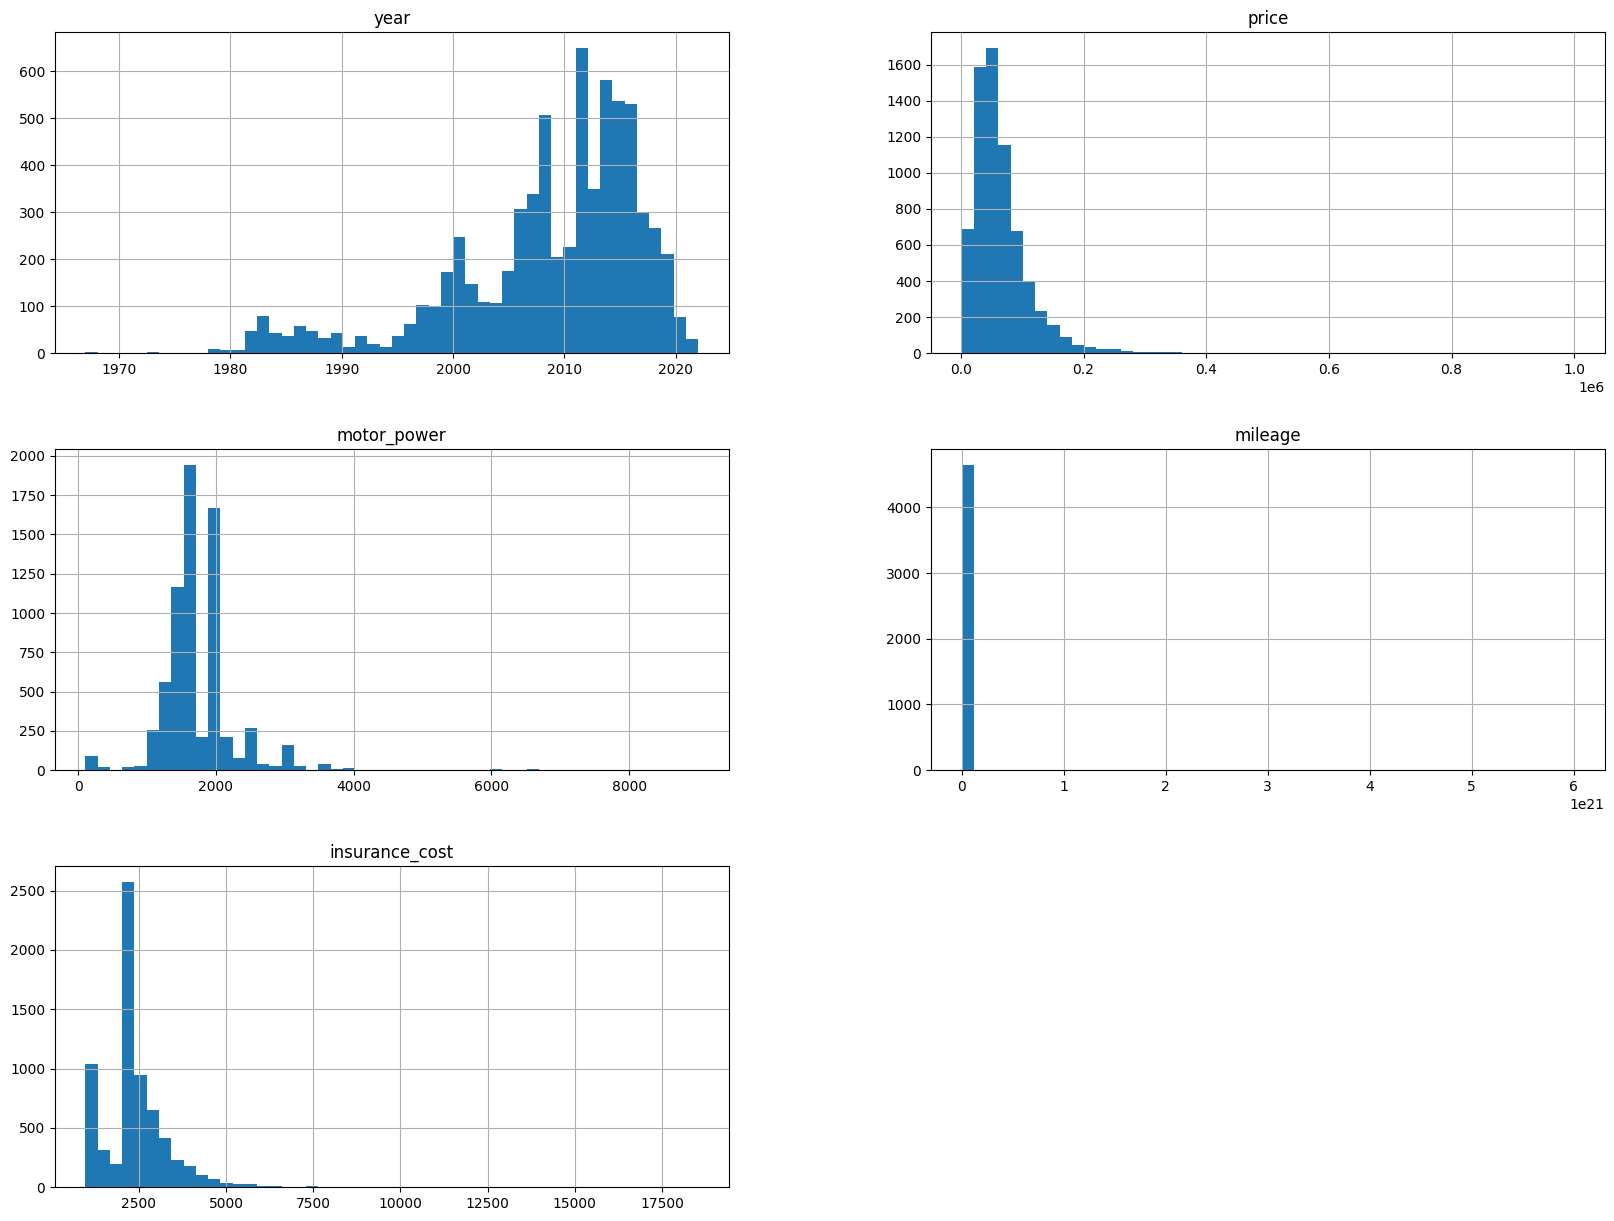

In [248]:
car_data.hist(bins=50, figsize=(20,15))

draw a horizontal bar plot for the categorical columns to see the distribution of the data

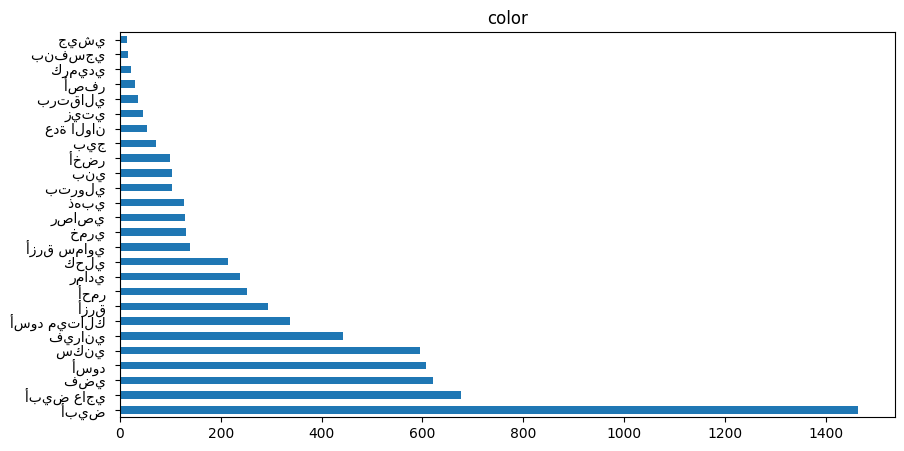

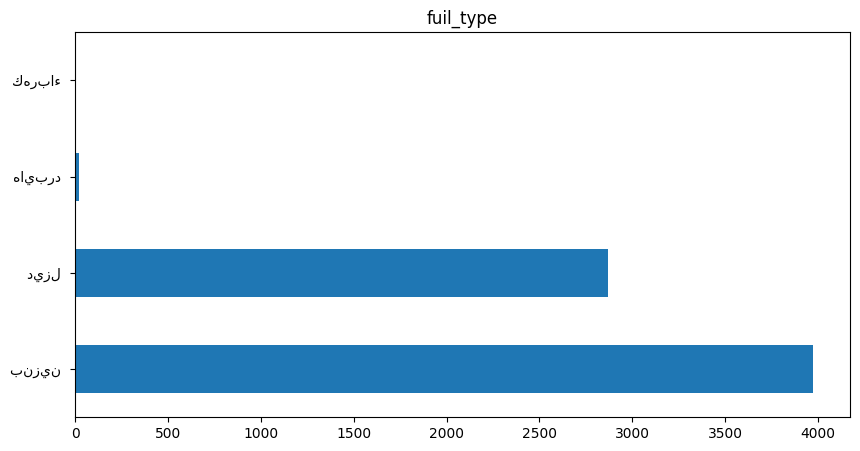

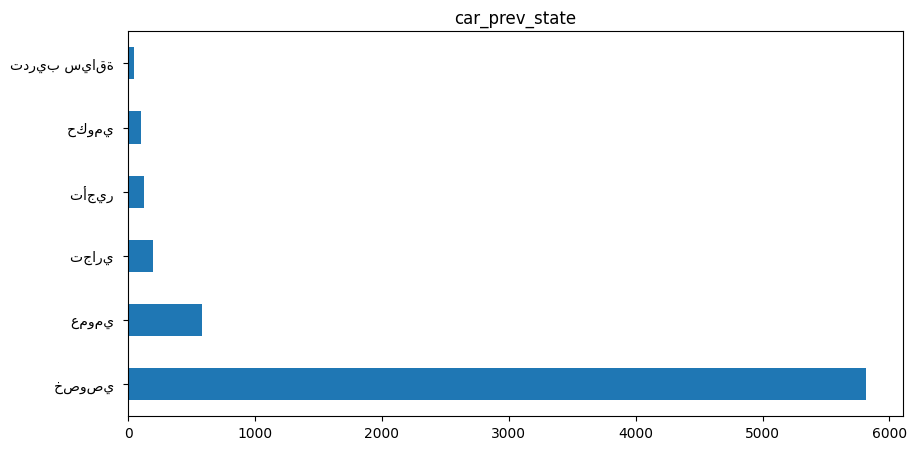

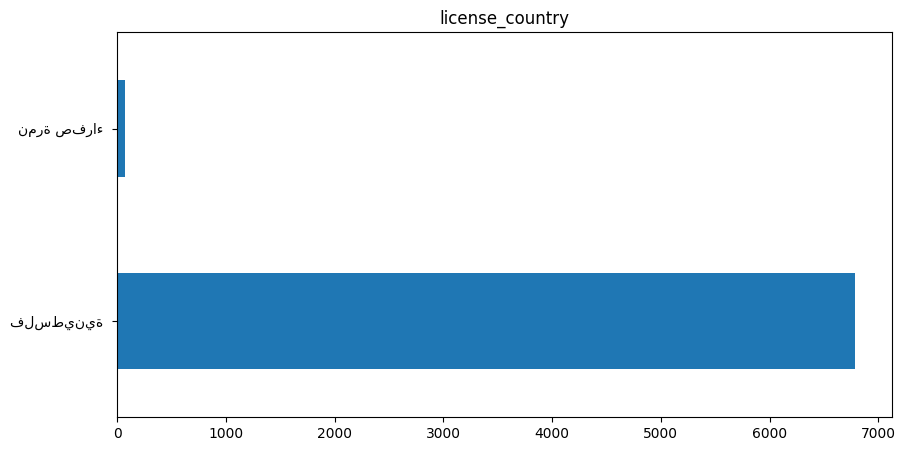

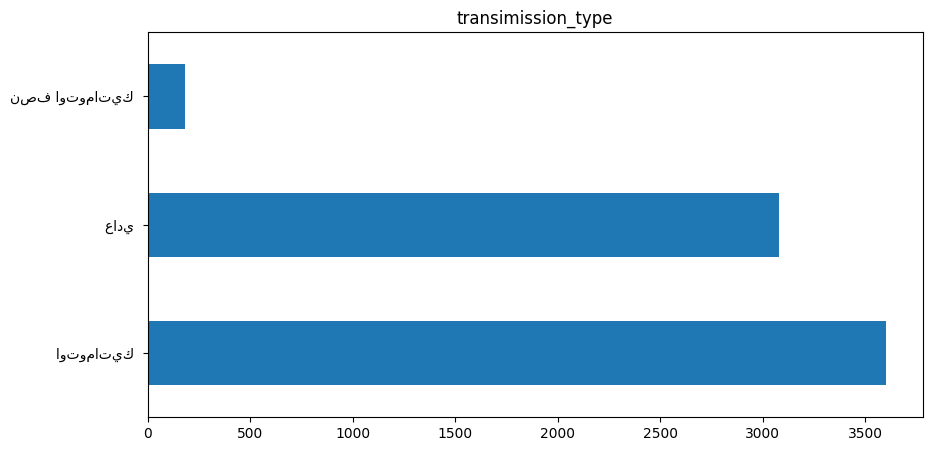

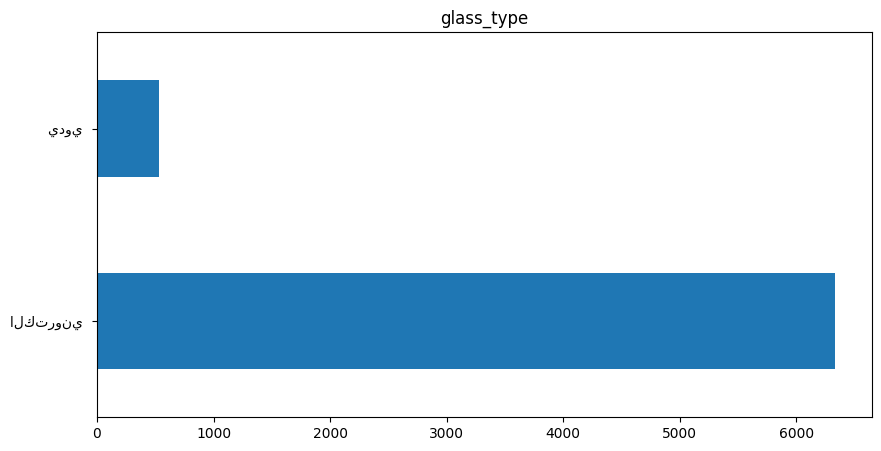

In [249]:
# draw a horizontal bar plot for the categorical columns to see the distribution of the data
def draw_bar_plot(df, col):
    df[col].value_counts().plot(kind='barh', figsize=(10, 5))
    plt.title(col)
    plt.show()
exiclude_columns = ['car_name','prev_owners','additional_info','sell_date','passenger_capacity']
for col in car_data.columns :
    if car_data[col].dtype == 'object' and col not in exiclude_columns:
        draw_bar_plot(car_data, col)

convert the sell_date column to datetime format

In [250]:
car_data['sell_date'] = pd.to_datetime(car_data['sell_date'])

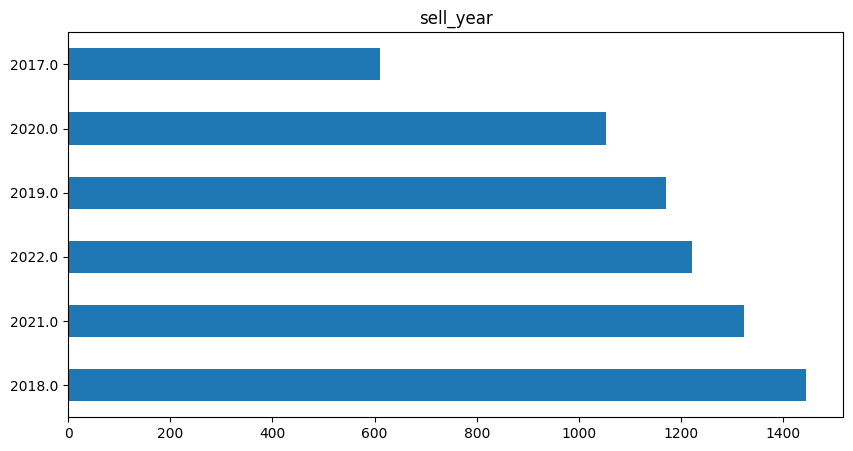

In [251]:
car_data['sell_year'] = car_data['sell_date'].dt.year
car_data['sell_year'].value_counts().plot(kind='barh', figsize=(10, 5))
plt.title('sell_year')
plt.show()

In [252]:
car_data.drop(columns=['sell_year'], inplace=True)

<h1 align="center" style="color:yellow">Missing Values Handling</h1> 


draw a horizontal bar plot for the number of null values in each column

<AxesSubplot: >

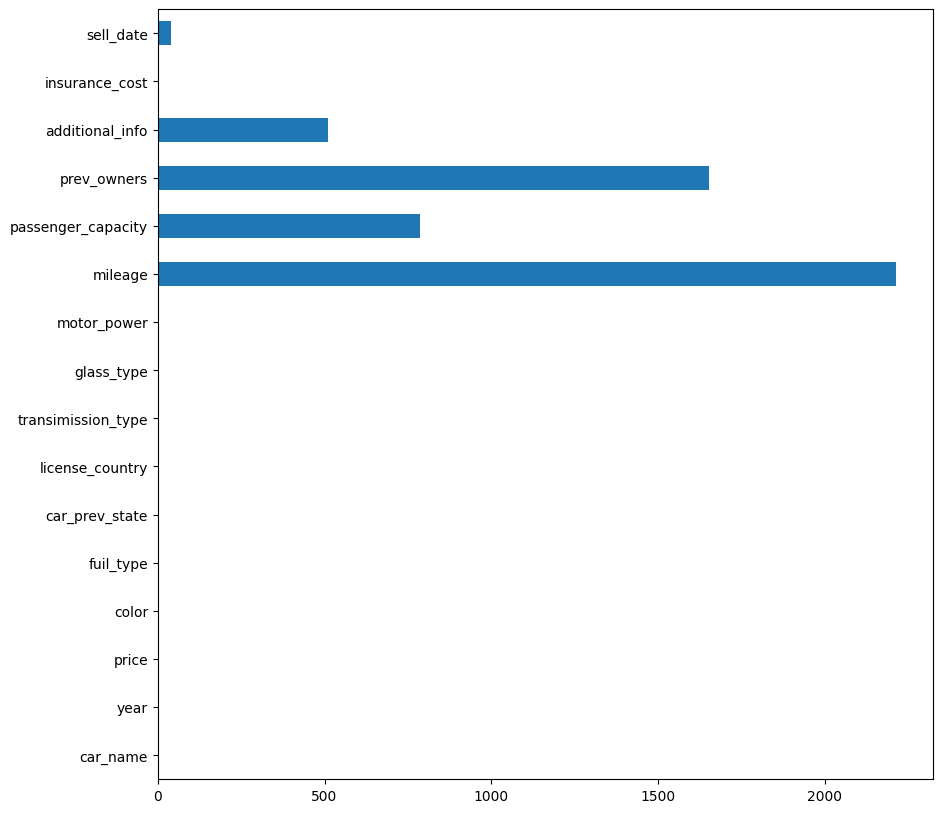

In [253]:
car_data.isnull().sum().plot(kind='barh', figsize=(10, 10))

fill the null values of the additional_info column with empty string ''
becouse if its null it means that there is no additional info

In [254]:
car_data['additional_info'].fillna('', inplace=True)

fill the null values for the sell_date with the ffill method (forward fill) becouse the data is nearly sorted by date and the null values are in the end of the data

In [255]:
car_data['sell_date'].fillna(method='ffill', inplace=True)

apply the function to the prev_owner column and convert it to int type 

the prev owner column is plain text so we need to convert it to int by applying the function to the column then we can fix the null values using the mean of the values for the same year model

In [256]:
car_data['prev_owners'] = car_data['prev_owners'].apply(normalize_prev_owner) # convert the prev_owners column to numeric if the function couldn't convert the value it will return NaN

In [257]:
car_data['prev_owners'].unique()

array(['1', '2', nan, '0', '4', '3', '8', '6', '5', '9', '7', '159000',
       '12', '10', '11', '56', '13', '16', '17', '78888877766', '15',
       '170000', '18', '123423', '14', '12345', '1000', '778244', '19',
       '11111', '44444'], dtype=object)

fix the null values for the prev_owners column using the mean of the values for the same year model

In [258]:
car_data = car_data.apply(fill_by_mean_mode_of_year, args=(car_data,'prev_owners'),axis=1)

In [259]:
car_data[car_data['prev_owners'].isna()]  # we have 3 rows with NaN values in the prev_owners column after filling the missing values by the mean of the year 
# so we will drop these rows


,car_name,year,price,color,fuil_type,car_prev_state,license_country,transimission_type,glass_type,motor_power,mileage,passenger_capacity,prev_owners,additional_info,insurance_cost,sell_date
173,مرسيدس 200,1978,15000,ذهبي,بنزين,عمومي,فلسطينية,اوتوماتيك,يدوي,2000,NaN,4+1,NaN,"مسجل CD,جنطات مغنيسيوم",1170,2017-09-24
3760,بي ام دبليو 320,1978,18000,ذهبي,بنزين,خصوصي,فلسطينية,عادي,يدوي,2000,0.0,4+1,NaN,"إغلاق مركزي,فتحة سقف,جنطات مغنيسيوم,فرش جلد",1170,2020-08-02
4586,فولكسفاجن فينتو,1968,40000,أصفر,بنزين,خصوصي,فلسطينية,عادي,يدوي,1300,286000.0,NaN,NaN,فرش جلد,1017,2021-04-15


In [260]:
car_data.dropna(subset=['prev_owners'], inplace=True)
car_data['prev_owners'] = car_data['prev_owners'].astype('int64')
car_data['prev_owners'].unique()

array([          1,           2,           0,           4,           3,
                 8,           6,           5,           9,           7,
            159000,          12,          10,          11,          18,
                56,          13,          16,          17, 78888877766,
                15,      170000,      123423,          14,       12345,
              1000,      778244,          19,       11111,       44444],
      dtype=int64)

In [261]:
car_data['passenger_capacity'].unique()

array(['4+1 ', '7+1 ', nan, '4+1  ', '5+1 ', '٤+١ ', '8 ', '6+1 ', '4+١ ',
       '٧ ', '7,+ 1 ', '7:1 ', '1+7 ', '١+٤ ', '2+1 ', '6+١ ', '+1 ',
       '6±١ ', '22 ', '1+1 ', '٥+١ ', '٧+1 ', '5+2 ', 'مثال: 4 + 1 ',
       '7.1 ', '7 =1 ', '٧+١ ', '6x1     ', '1+٤ ', '1+2 ', '4+1   ',
       '2/1 ', '8+1 ', '4+2 ', '٦+١ ', '2 ', '1٠4 ', '4\\١ ', '000 ',
       '3+1 ', '1 ', 'اكثر من 10 ', '9+1 '], dtype=object)

the passenger_capacity columns is meant to be int but it written as string equation so we need to convert it to int 

In [262]:
car_data['passenger_capacity'] = car_data['passenger_capacity'].apply(arabic_to_english)

In [263]:
car_data['passenger_capacity'].unique()

array([ 5.,  8., nan,  6.,  7.,  3.,  1.,  4.,  2.,  9.,  0., 10.])

to handle the missing values of the passenger_capacity column we will use the KNNImputer from sklearn.impute </br >
the KNNImputer will impute the missing values by using the k nearest neighbors found in the dataset  </br >
the reason we use the KNNImputer is becouse the KNN is based on the distance of the k nearest and this value is most likely to be the same as the similar cars </br > 

In [264]:
imputer = KNNImputer(n_neighbors=5,)
car_data['passenger_capacity'] = imputer.fit_transform(car_data[['passenger_capacity']])
car_data['passenger_capacity'] = car_data['passenger_capacity'].astype(int)


In [265]:
car_data[car_data['passenger_capacity'].isna()]

,car_name,year,price,color,fuil_type,car_prev_state,license_country,transimission_type,glass_type,motor_power,mileage,passenger_capacity,prev_owners,additional_info,insurance_cost,sell_date


the mileage is numaric but have a alot of missing values so we will use the mean of the values for the same year model to fill the missing values 

In [266]:
car_data['mileage'] = car_data['mileage'].astype(object) # convert the mileage column to object to apply the convert_numbers function
car_data = car_data.apply(fill_by_mean_mode_of_year,args=(car_data,'mileage'), axis=1)

In [267]:
car_data[car_data['mileage'].isna()]

,car_name,year,price,color,fuil_type,car_prev_state,license_country,transimission_type,glass_type,motor_power,mileage,passenger_capacity,prev_owners,additional_info,insurance_cost,sell_date
345,فيات 127,1975,13000,أخضر,بنزين,خصوصي,فلسطينية,عادي,الكتروني,900,NaN,5,5,"جهاز إنذار,مسجل CD,جنطات مغنيسيوم,فرش جلد",967,2017-10-30
4247,فولكسفاجن جولف,1976,7000,أحمر,بنزين,خصوصي,فلسطينية,عادي,يدوي,1000,NaN,5,7,"مسجل CD,جنطات مغنيسيوم,فرش جلد",967,2020-12-17


In [268]:
car_data.dropna(subset=['mileage'], inplace=True)

In [269]:
car_data.isnull().sum()

car_name              0
year                  0
price                 0
color                 0
fuil_type             0
car_prev_state        0
license_country       0
transimission_type    0
glass_type            0
motor_power           0
mileage               0
passenger_capacity    0
prev_owners           0
additional_info       0
insurance_cost        0
sell_date             0
dtype: int64

# Noisy  Data and Outliers 

take a look at the descriptive statistics of the numerical columns 

In [270]:
car_data.dtypes

car_name                      object
year                           int64
price                          int64
color                         object
fuil_type                     object
car_prev_state                object
license_country               object
transimission_type            object
glass_type                    object
motor_power                    int64
mileage                      float64
passenger_capacity             int64
prev_owners                    int64
additional_info               object
insurance_cost                 int64
sell_date             datetime64[ns]
dtype: object

In [271]:
car_data.describe()

,year,price,motor_power,mileage,passenger_capacity,prev_owners,insurance_cost
count,6859.000000,6859.000000,6859.000000,6.859000e+03,6859.000000,6.859000e+03,6859.000000
mean,2008.616271,66756.614229,1740.080041,8.757646e+17,5.211401,1.150171e+07,2422.720805
std,8.659547,56848.387273,588.857086,7.253002e+19,0.899878,9.525447e+08,1083.776163
min,1967.000000,1111.000000,106.000000,0.000000e+00,0.000000,0.000000e+00,967.000000
25%,2005.000000,36000.000000,1400.000000,0.000000e+00,5.000000,1.000000e+00,2035.000000
50%,2011.000000,55000.000000,1600.000000,3.900000e+04,5.000000,2.000000e+00,2340.000000
75%,2015.000000,82000.000000,2000.000000,1.000000e+05,5.000000,3.000000e+00,2756.500000
max,2022.000000,999999.000000,9000.000000,6.006870e+21,10.000000,7.888888e+10,18535.000000


compute the interquartile range (IQR) for each numerical column
the IQR is the difference between the 75th and 25th percentile
helps us to detect outliers

In [272]:
Q1 = car_data.quantile(0.25)
Q3 = car_data.quantile(0.75)
IQR = Q3 - Q1
IQR

C:\Users\nasser\AppData\Local\Temp\ipykernel_14660\3964405416.py:1: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q1 = car_data.quantile(0.25)
C:\Users\nasser\AppData\Local\Temp\ipykernel_14660\3964405416.py:2: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q3 = car_data.quantile(0.75)


year                      10.0
price                  46000.0
motor_power              600.0
mileage               100000.0
passenger_capacity         0.0
prev_owners                2.0
insurance_cost           721.5
dtype: float64

compute the skewness of the numerical columns

In [273]:
car_data.skew()

C:\Users\nasser\AppData\Local\Temp\ipykernel_14660\945382517.py:1: FutureWarning: The default value of numeric_only in DataFrame.skew is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  car_data.skew()


year                  -1.310555
price                  5.056875
motor_power            2.843267
mileage               82.819080
passenger_capacity     0.876538
prev_owners           82.819080
insurance_cost         3.480413
dtype: float64

remove the outliers from the numerical columns using the IQR method 

In [274]:
car_data['motor_power'].describe()
# remove the outliers rows from the motor_power column
car_data = car_data[~((car_data['motor_power'] < (Q1['motor_power'] - 1.5 * IQR['motor_power'])) |(car_data['motor_power'] > (Q3['motor_power'] + 1.5 * IQR['motor_power'])))]
# remove the outliers rows from the mile_age column
car_data = car_data[~((car_data['mileage'] < (Q1['mileage'] - 1.5 * IQR['mileage'])) |(car_data['mileage'] > (Q3['mileage'] + 1.5 * IQR['mileage'])))]
# remove the outliers rows from the insurance_cost column
car_data = car_data[~((car_data['insurance_cost'] < (Q1['insurance_cost'] - 1.5 * IQR['insurance_cost'])) |(car_data['insurance_cost'] > (Q3['insurance_cost'] + 1.5 * IQR['insurance_cost'])))]

In [275]:
car_data.describe()

,year,price,motor_power,mileage,passenger_capacity,prev_owners,insurance_cost
count,5816.000000,5816.000000,5816.000000,5816.000000,5816.000000,5.816000e+03,5816.000000
mean,2008.485213,57043.578061,1659.304849,52342.993294,5.197215,1.356417e+07,2244.945667
std,8.714767,30416.802293,357.470359,62779.961605,0.765866,1.034436e+09,667.186375
min,1967.000000,1111.000000,500.000000,0.000000,0.000000,0.000000e+00,967.000000
25%,2005.000000,35000.000000,1400.000000,0.000000,5.000000,1.000000e+00,2035.000000
50%,2011.000000,52000.000000,1600.000000,24494.500000,5.000000,2.000000e+00,2340.000000
75%,2015.000000,75000.000000,2000.000000,92000.000000,5.000000,3.000000e+00,2653.000000
max,2022.000000,158000.000000,2900.000000,250000.000000,10.000000,7.888888e+10,3826.000000


# Feature Engineering 

all features extraction and above feature transformation incapsulated in a custom transformers  found in src/transformers.py to be used in the pipeline </br>
the transformers are: </br>
- DateTransformer: extract the year from the sell_date column </br>
- PrevOwnerTransformer : extract the number of previous owners from the prev_owner column  and handle the missing values after the extraction </br>
- PassengerCpacityTransformer : extract the passenger capacity from the passenger_capacity column and handle the missing values after the extraction </br>
- NominalTransformer : using the one hot encoder to encode the nominal columns </br>
- OrdenalTransformer : using the label encoder to encode the ordinal columns  based on given order </br>
- ColorTransformer : delete the color column becouse it has alot of unique values and it will make the model overfit </br>
- AdditionalInfoTransformer : using the one hot encoder to encode the additional_info column </br>



In [276]:
car_data.columns

Index(['car_name', 'year', 'price', 'color', 'fuil_type', 'car_prev_state',
       'license_country', 'transimission_type', 'glass_type', 'motor_power',
       'mileage', 'passenger_capacity', 'prev_owners', 'additional_info',
       'insurance_cost', 'sell_date'],
      dtype='object')

In [277]:
nomenal_features = ['fuil_type','transimission_type']
ordinal_features = [ 'glass_type', 'car_prev_state','license_country']

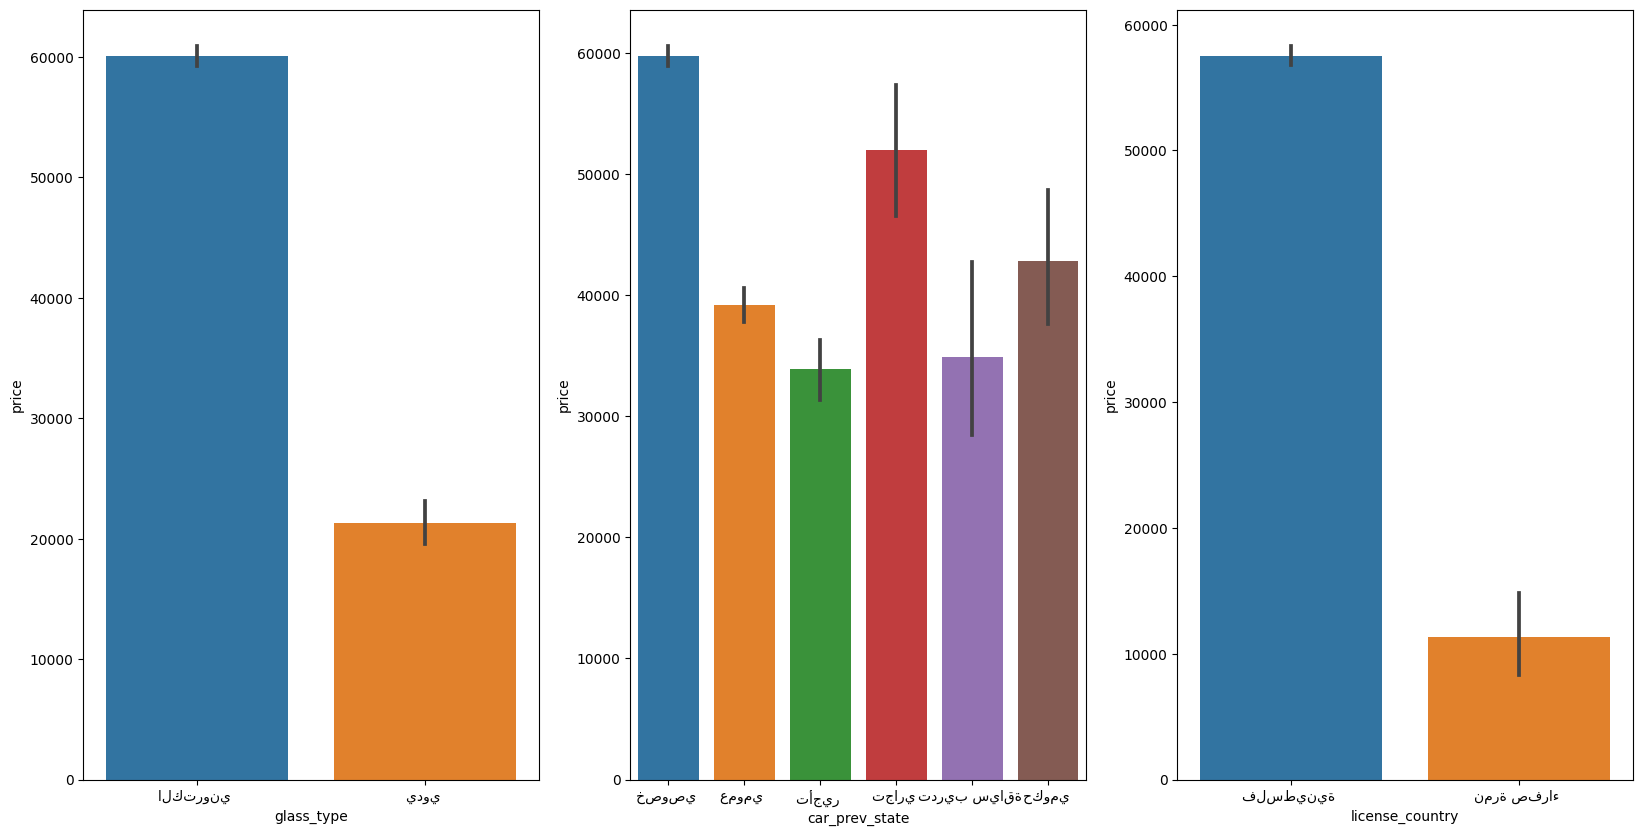

In [278]:


plt.figure(figsize=(20, 10))
for index,feature in enumerate(ordinal_features):
    plt.subplot(1, 3, index+1)
    sns.barplot(x=feature, y='price', data=car_data)
    #the arabic text is flipped so i used this code to fix it


In [279]:
#define the order of the values for each feature 

ordinal_order = {
    'glass_type':{
        'يدوي ':1,
        'الكتروني ':2
    },
    'car_prev_state':{
        'خصوصي ':1,
        'تجاري ':2,
        'حكومي ':3,
        'عمومي ':4,
        'تدريب سياقة ':5,
       'تأجير ':6
    },
    'license_country':{
        'فلسطينية ':1,
        'نمرة صفراء ':2
    }
}

<AxesSubplot: xlabel='color', ylabel='price'>

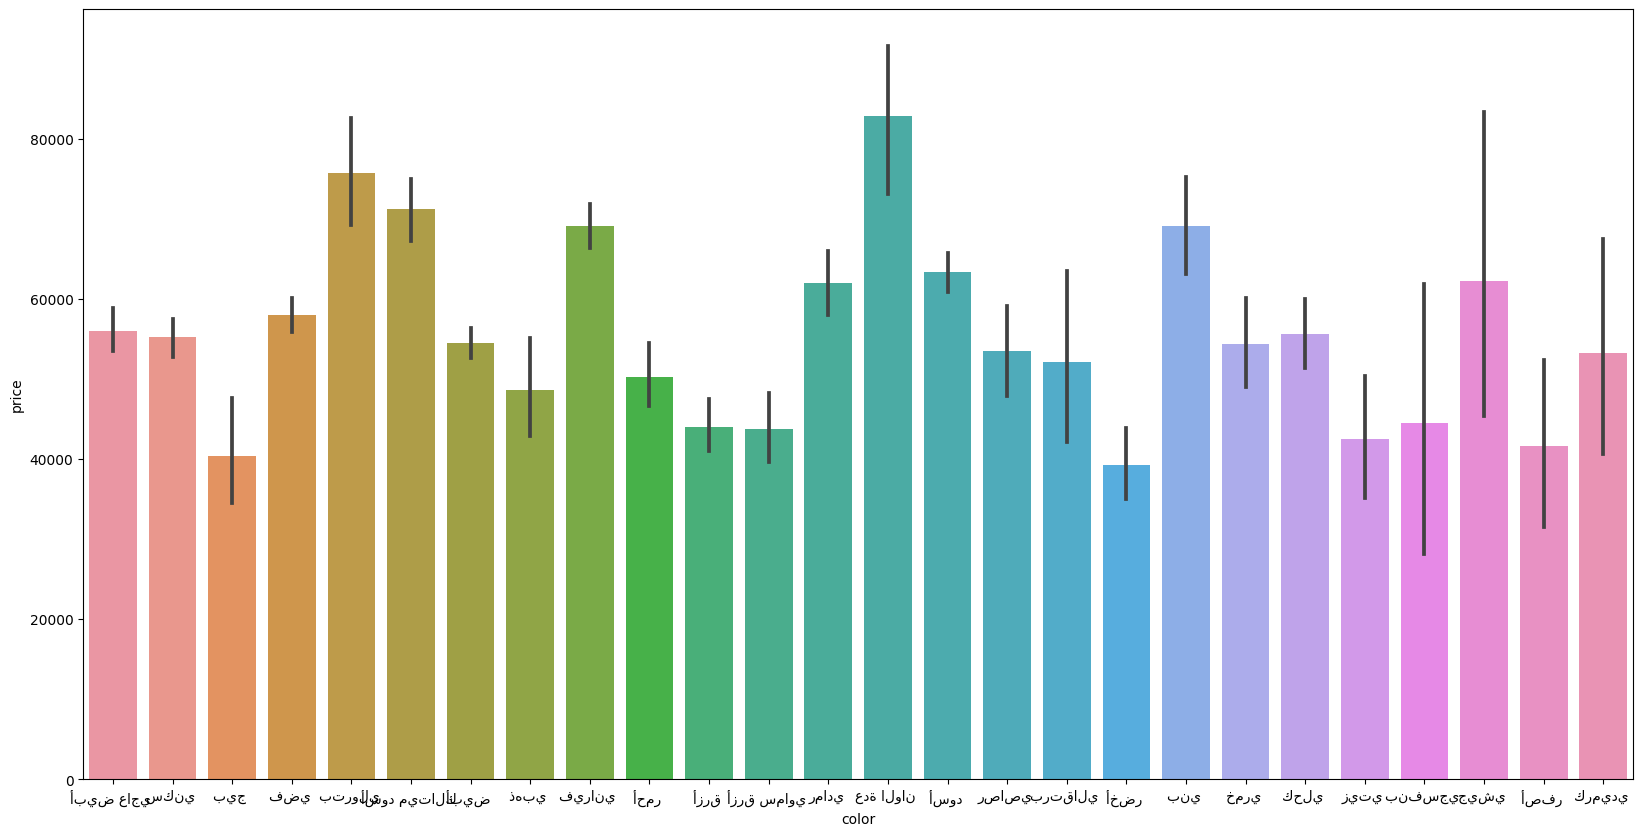

In [280]:
# see if the color has effect on the price or not
plt.figure(figsize=(20, 10))
sns.barplot(x='color', y='price', data=car_data)


In [281]:
steps = [("Date Transform", ct.DateTransformer(column='sell_date')),
         ("Prev_owner Transformer", ct.PrevOwnerTransformer(column='prev_owners')),
         ("Passenger Capacity Transformer", ct.PassengerCpacityTransformer(column='passenger_capacity')),
         ("Nominal Transformer", ct.NominalTransformer(columns=nomenal_features)),
         ("Ordenal Transformer", ct.OrdenalTransformer(columns=ordinal_features, order_dict=ordinal_order)),
         ("Color Transformer", ct.ColorTransformer(column='color')),
         ("Additional Info Transformer", ct.AdditionalInfoTransformer(column='additional_info')),]
pip = Pipeline(steps)
car_data = pip.fit_transform(car_data)
car_data.drop(columns=['car_name'], inplace=True)



In [282]:
car_data

,year,price,car_prev_state,license_country,glass_type,motor_power,mileage,passenger_capacity,prev_owners,insurance_cost,sell_date.year,بنزين,ديزل,كهرباء,هايبرد,اوتوماتيك,عادي,نصف اوتوماتيك,مسجل CD,جهاز إنذار,جنطات مغنيسيوم,فرش جلد,وسادة حماية هوائية,إغلاق مركزي,فتحة سقف,مُكيّف
0,2014,100000,1,1,2,2000,75000.0,5,1,3090,2017,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1,1,1,1,1,1,1
1,2007,60000,1,1,2,2500,130000.0,8,2,2740,2017,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1,1,1,1,1,1,1,1
2,2006,43500,1,1,2,1600,0.0,5,2,2340,2017,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1,1,1,1,1,0,1
3,1982,5500,1,1,1,906,0.0,5,0,967,2017,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0,0,0,0,0,0,1
4,2014,54000,1,1,2,1200,38000.0,5,1,2035,2017,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0,1,1,0,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5811,2019,95000,1,1,2,1000,49000.0,5,1,2598,2022,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1,0,0,1,1,0,1
5812,2011,45000,1,1,2,1600,0.0,5,2,2340,2022,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,1,1,0,1,1,0,1
5813,2019,97000,1,1,2,1000,70000.0,5,0,2633,2022,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0,1,1,1,1,1,0,1
5814,2019,82000,1,1,2,1600,70000.0,5,0,2775,2022,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1,1,1,1,1,1,1


In [296]:
# # #polynomial regression
# from sklearn.preprocessing import PolynomialFeatures
# from sklearn.linear_model import LinearRegression
# from sklearn.model_selection import train_test_split   
# # apply normalization to the data using sklearn
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# scaler.fit(car_data)
# car_data = pd.DataFrame(scaler.transform(car_data), columns=car_data.columns)
# x_train, x_test, y_train, y_test = train_test_split(car_data.drop('price', axis=1), car_data['price'], test_size=0.33, random_state=42)
# poly = PolynomialFeatures(degree=2)
# x_train_poly = poly.fit_transform(x_train)
# x_test_poly = poly.fit_transform(x_test)
# poly.fit(x_train_poly, y_train)
# model = LinearRegression()
# model.fit(x_train_poly, y_train)
# print(model.score(x_train_poly, y_train))
# print(model.score(x_test_poly, y_test))

# the model is overfitting so we will use regularization Rige with polynomial features 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split   
# apply normalization to the data using sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge
scaler = MinMaxScaler()
scaler.fit(car_data)
car_data = pd.DataFrame(scaler.transform(car_data), columns=car_data.columns)
x_train, x_test, y_train, y_test = train_test_split(car_data.drop('price', axis=1), car_data['price'], test_size=0.33, random_state=42)
# poly = PolynomialFeatures(degree=5)
# x_train_poly = poly.fit_transform(x_train)
# x_test_poly = poly.fit_transform(x_test)

# model = Ridge(alpha=0.1)
# model.fit(x_train_poly, y_train)
# print(model.score(x_train_poly, y_train))
# print(model.score(x_test_poly, y_test))


# draw a plot to determine the best alpha value and the best degree for the polynomial features in 3d plot
# max_degree = 5
# scores = []
# for degree in range(1, max_degree+1):
#     poly = PolynomialFeatures(degree=degree)
#     x_train_poly = poly.fit_transform(x_train)
#     x_test_poly = poly.fit_transform(x_test)
#     for alpha in np.arange(0.1, 1.1, 0.1):
#         model = Ridge(alpha=alpha)
#         model.fit(x_train_poly, y_train)
#         scores.append([degree, alpha, model.score(x_train_poly, y_train), model.score(x_test_poly, y_test)])
# scores = pd.DataFrame(scores, columns=['degree', 'alpha', 'train_score', 'test_score'])
# scores



0.7631073843762801
-2394499.17786292


In [292]:
# scores['diff'] = scores['train_score'] - scores['test_score']
# # see  the score[diff] in a plot
# scores

,degree,alpha,train_score,test_score,diff
0,1,0.1,0.763156,0.752386,0.010770
1,1,0.2,0.763155,0.752412,0.010744
2,1,0.3,0.763154,0.752436,0.010718
3,1,0.4,0.763152,0.752460,0.010692
4,1,0.5,0.763149,0.752483,0.010666
5,1,0.6,0.763146,0.752506,0.010640
6,1,0.7,0.763142,0.752527,0.010615
7,1,0.8,0.763138,0.752548,0.010590
8,1,0.9,0.763133,0.752568,0.010565
9,1,1.0,0.763127,0.752588,0.010540


In [293]:
# # get the index of the best model
# best_model_index = scores['diff'].idxmin() 
# best_model_index

9

([<matplotlib.axis.XTick at 0x2cc627b52e0>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9')])

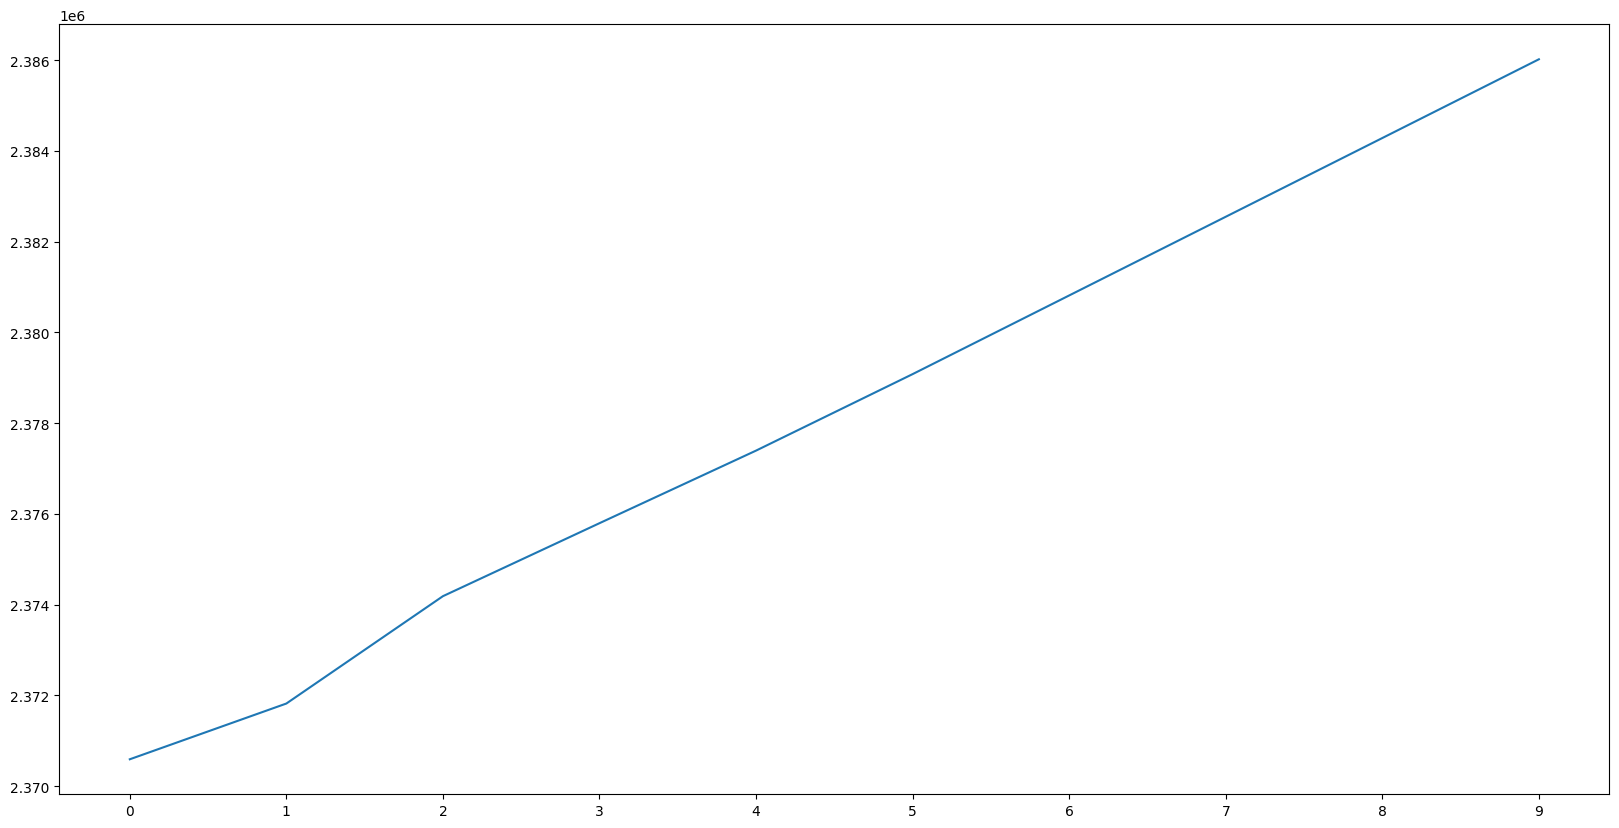

In [286]:
# # draw the index in x-axis and the diff in y-axis but show all the x-axis values
# plt.figure(figsize=(20, 10))
# plt.plot(scores['diff'])
# plt.xticks(range(len(scores['diff'])), scores['diff'].index)

C:\Users\nasser\AppData\Local\Temp\ipykernel_14660\3172705303.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  plt = sns.heatmap(scores.pivot('degree', 'alpha', 'train_score'), annot=True, fmt='.2f')


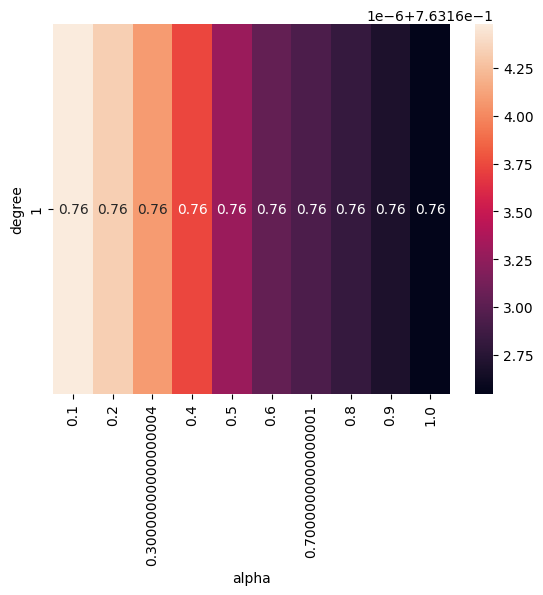

In [287]:
# plt = sns.heatmap(scores.pivot('degree', 'alpha', 'train_score'), annot=True, fmt='.2f')


In [288]:
# # decision tree
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.model_selection import train_test_split
# x_train, x_test, y_train, y_test = train_test_split(car_data.drop('price', axis=1), car_data['price'], test_size=0.33, random_state=42)
# model = DecisionTreeRegressor()
# model.fit(x_train, y_train)
# print(model.score(x_train, y_train))

# # print the score of the model on the test data
# print(model.score(x_test, y_test))

In [289]:
# # KNN 
# from sklearn.neighbors import KNeighborsRegressor
# from sklearn.model_selection import train_test_split
# x_train, x_test, y_train, y_test = train_test_split(car_data.drop('price', axis=1), car_data['price'], test_size=0.33, random_state=42)
# model = KNeighborsRegressor(n_neighbors=5)
# model.fit(x_train, y_train)
# print(model.score(x_train, y_train))
# print(model.score(x_test, y_test))

0.8801266901442801
0.7843796514898268
